# Análise de dados

In [1]:
# Configurações
DATA_CSV = 'TR-SLD_v1-4a_shuffled_balanced.csv'
DATA_FRMT = 'wav'
DATASET = 'SLD_v1-4a'
GROUP = 'train'
RANDOM_SAMPLES = 500  # Use None to load all dataset

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import IPython.display as ipd  # To play sound in the notebook
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.tools as tls
import wave
import librosa
import os
import glob
import pandas
import tqdm
import random
from tqdm import tqdm_notebook
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

In [3]:
%matplotlib inline 
color = sns.color_palette()
py.init_notebook_mode(connected=True)
offline.init_notebook_mode()

In [4]:
data = pandas.read_csv(DATA_CSV)
data.columns = ['file_path', 'label']

In [5]:
# Fix the path
data['file_path'] = data['file_path'].apply(lambda fp: fp[23:])

In [6]:
data.head()

file_path   label
0  train/de\de_f_5d2e7\de_f_5d2e7__rmx__lp6000.00...  deutch
1  train/de\de_m_0345d\de_m_0345d__rmx__lp6000.00...  deutch
2  train/de\de_m_ce41a\de_m_ce41a__rmx__lp6000.00...  deutch
3  train/de\de_f_0809f\de_f_0809f__rmx__lp6000.00...  deutch
4  train/de\de_f_6cc5c\de_f_6cc5c__rmx__lp6000.00...  deutch

In [7]:
def load_wav_file(path):
    sr, b = wavfile.read(path)
    return sr, b

In [8]:
# Load data
if not RANDOM_SAMPLES:
    # Samples == data
    wavs = dict()
    wavs['time_series'] = []
    wavs['sample_rate'] = []
    for path in data['file_path']:
        sr, b = wavfile.read(path)
        wavs['time_series'].append(b)
        wavs['sample_rate'].append(sr)
    samples = pandas.DataFrame(wavs, columns = ['file_path', 'time_series', 'sample_rate'])
    samples['file_path'] = data['file_path']
else:
    # Load #RANDOM_SAMPLES samples
    samples = dict()
    samples['time_series'] = []
    samples['sample_rate'] = []
    df_samples = data.sample(RANDOM_SAMPLES)
    for path in df_samples['file_path']:
        sr, b = wavfile.read(path)
        samples['sample_rate'].append(sr)
        samples['time_series'].append(b)
    df_samples['sample_rate'] = samples['sample_rate']
    df_samples['time_series'] = samples['time_series']
    samples = df_samples
    
samples['label'] = data['label']
samples['nframes'] = samples['time_series'].apply(len)
# The file name is an abreviation
## WARNING: Be careful when changing the number of characters selected, because the analysis of 
## speakers was made based on the name of file
samples['file_name'] = samples['file_path'].apply(lambda p: p.split(os.sep)[-1])
samples.head(40)

file_path       label  \
31370  train/fr\fr_f_799c7\fr_f_799c7__rmx__lp6000.00...      french   
44012  train/pt\pt_f_52518\pt_f_52518__rmx__lp6000.00...  portuguese   
49244  train/pt\pt_m_bcb9d\pt_m_bcb9d__rmx__lp6000.00...  portuguese   
44563  train/pt\pt_m_27085\pt_m_27085__rmx__lp6000.00...  portuguese   
39498  train/pt\pt_m_05e97\pt_m_05e97__rmx__lp6000.00...  portuguese   
1001   train/de\de_m_df90b\de_m_df90b__rmx__lp6000.00...      deutch   
61969  train/es\es_m_76852\es_m_76852__rmx__lp6000.00...     spanish   
29308  train/fr\fr_f_95f5e\fr_f_95f5e__rmx__lp6000.00...      french   
8849   train/de\de_m_0345d\de_m_0345d__rmx__lp6000.00...      deutch   
9335   train/de\de_m_8ea35\de_m_8ea35__rmx__lp6000.00...      deutch   
38699  train/fr\fr_f_95f5e\fr_f_95f5e__rmx__lp6000.00...      french   
7357   train/de\de_m_50229\de_m_50229__rmx__lp6000.00...      deutch   
42207  train/pt\pt_f_75573\pt_f_75573__rmx__lp6000.00...  portuguese   
16893  train/en\en_m_68767\en_m_68767__rmx__lp6000.00...     english   
13380  train/en\en_f_b6f3c\en_f_b6f3c__rmx__lp6000.00...     english   
64372  train/es\es_m_76852\es_m_76852__rmx__lp6000.00...     spanish   
47972  train/pt\pt_m_0c95f\pt_m_0c95f__rmx__lp6000.00...  portuguese   
54860  train/es\es_f_68e1d\es_f_68e1d__rmx__lp6000.00...     spanish   
41450  train/pt\pt_f_37eb7\pt_f_37eb7__rmx__lp6000.00...  portuguese   
23272  train/en\en_m_29119\en_m_29119__rmx__lp6000.00...     english   
40126  train/pt\pt_m_af474\pt_m_af474__rmx__lp6000.00...  portuguese   
8573   train/de\de_m_d2253\de_m_d2253__rmx__lp6000.00...      deutch   
55798  train/es\es_f_56ef0\es_f_56ef0__rmx__lp6000.00...     spanish   
14620  train/en\en_m_29119\en_m_29119__rmx__lp6000.00...     english   
41536  train/pt\pt_m_af474\pt_m_af474__rmx__lp6000.00...  portuguese   
51494  train/pt\pt_m_05e97\pt_m_05e97__rmx__lp6000.00...  portuguese   
27990  train/fr\fr_m_a93c8\fr_m_a93c8__rmx__lp6000.00...      french   
58384  train/es\es_m_534a0\es_m_534a0__rmx__lp6000.00...     spanish   
63254  train/es\es_f_1d27c\es_f_1d27c__rmx__lp6000.00...     spanish   
241    train/de\de_f_f856a\de_f_f856a__rmx__lp6000.00...      deutch   
15088  train/en\en_f_17211\en_f_17211__rmx__lp6000.00...     english   
17477  train/en\en_f_17211\en_f_17211__rmx__lp6000.00...     english   
30741  train/fr\fr_m_3c5d7\fr_m_3c5d7__rmx__lp6000.00...      french   
57753  train/es\es_m_d5b91\es_m_d5b91__rmx__lp6000.00...     spanish   
12072  train/de\de_m_3aa01\de_m_3aa01__rmx__lp6000.00...      deutch   
47038  train/pt\pt_m_af474\pt_m_af474__rmx__lp6000.00...  portuguese   
62770  train/es\es_m_b5327\es_m_b5327__rmx__lp6000.00...     spanish   
13891  train/en\en_f_25836\en_f_25836__rmx__lp6000.00...     english   
16600  train/en\en_m_81995\en_m_81995__rmx__lp6000.00...     english   
15256  train/en\en_f_058b7\en_f_058b7__rmx__lp6000.00...     english   

       sample_rate                                        time_series  \
31370        16000  [-994, -902, -842, -833, -746, -584, -421, -24...   
44012        16000  [-1572864, -36470784, -59998208, -70025216, -7...   
49244        16000  [142, 149, 153, 168, 180, 183, 200, 219, 237, ...   
44563        16000  [37, 52, 55, 48, 38, 35, 36, 36, 36, 41, 67, 1...   
39498        16000  [-478, -572, -601, -595, -593, -601, -624, -62...   
1001         16000  [5, 7, 7, 14, 14, 18, 18, 19, 23, 17, 21, 30, ...   
61969        16000  [-7194, -8110, -8985, -9494, -9282, -8176, -59...   
29308        16000  [-132, -332, -394, -322, -288, -308, -302, -29...   
8849         16000  [1672, 1768, 1952, 2054, 2116, 2184, 2151, 216...   
9335         16000  [8484, 8865, 9223, 9462, 9496, 9500, 9471, 940...   
38699        16000  [-238, -360, -282, -158, -86, 134, 437, 610, 5...   
7357         16000  [35935744, 5274624, -16500352, -445312, 250470...   
42207        16000  [1148, -839, 1201, -308, 718, 576, -18, 1134, ...   
16893        16000  [197, 178, 27, -322, -720, -986, -1092, -1287,...   

In [9]:
data['file_name'] = data['file_path'].apply(lambda p: p.split(os.sep)[-1][:-4][:24])
full_names = [x.split(os.sep)[-1] for x in data['file_path']]
# Data augmentation
def gftrv(full_n, feature):
    x = full_n.split(feature, 1)
    if len(x) > 1:
        if feature == 'lp':
            return x[1].split('_')[0]
        return x[1].split('_')[1]
    return None
speeds = [gftrv(x, '_sp') for x in full_names]
pitches = [gftrv(x, '_pt') for x in full_names]
noises = [gftrv(x, '_ns') for x in full_names]
low_pass = [gftrv(x, '_lp') for x in full_names]
data['speed_changing'] = speeds
data['pitch_changing'] = pitches
data['noise_add'] = noises
data['low_pass'] = low_pass
data['augmented_data'] = list(map(lambda x: x[0] is not None or x[1] is not None or x[2] is not None or x[3] is not None,
                                 list(zip(speeds, pitches, noises, low_pass))))
export_csv = data.to_csv (r'[DF]{}'.format(DATA_CSV), index = None, header=True) 


In [10]:
data.head()

file_path   label  \
0  train/de\de_f_5d2e7\de_f_5d2e7__rmx__lp6000.00...  deutch   
1  train/de\de_m_0345d\de_m_0345d__rmx__lp6000.00...  deutch   
2  train/de\de_m_ce41a\de_m_ce41a__rmx__lp6000.00...  deutch   
3  train/de\de_f_0809f\de_f_0809f__rmx__lp6000.00...  deutch   
4  train/de\de_f_6cc5c\de_f_6cc5c__rmx__lp6000.00...  deutch   

                  file_name speed_changing pitch_changing noise_add low_pass  \
0  de_f_5d2e7__rmx__lp6000.           0.85           None      None            
1  de_m_0345d__rmx__lp6000.           None          100.0      None            
2  de_m_ce41a__rmx__lp6000.           None          200.0      None            
3  de_f_0809f__rmx__lp6000.           None          150.0      None            
4  de_f_6cc5c__rmx__lp6000.           0.95           None      None            

   augmented_data  
0            True  
1            True  
2            True  
3            True  
4            True

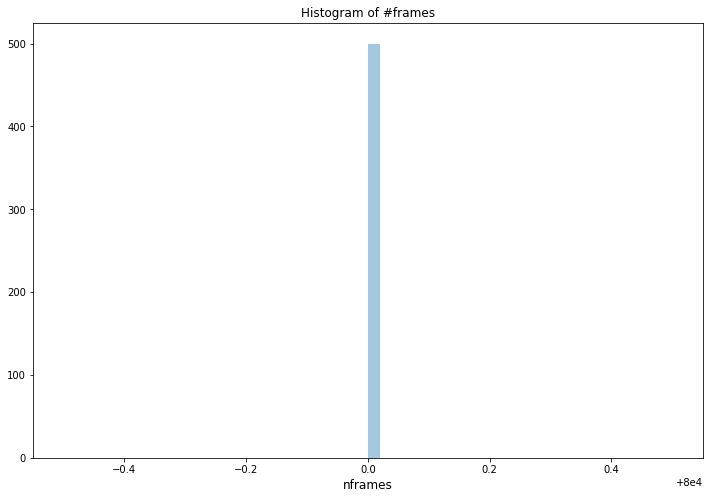

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(samples.nframes.values, bins=50, kde=False)
plt.xlabel('nframes', fontsize=12)
plt.title("Histogram of #frames")
plt.show()

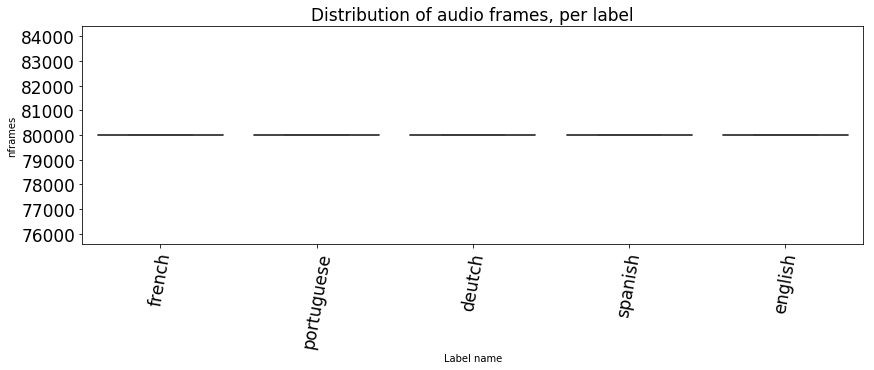

In [12]:
plt.figure(figsize=(14,4))
boxplot = sns.boxplot(x="label", y="nframes", data=samples)
boxplot.set(xlabel='', ylabel='')
plt.title('Distribution of audio frames, per label', fontsize=17)
plt.xticks(rotation=80, fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('Label name')
plt.ylabel('nframes')
plt.show()

In [13]:
temp = data.sort_values(by='label')
temp.head()

file_path   label  \
0     train/de\de_f_5d2e7\de_f_5d2e7__rmx__lp6000.00...  deutch   
8726  train/de\de_f_5d2e7\de_f_5d2e7__rmx__lp6000.00...  deutch   
8727  train/de\de_f_f856a\de_f_f856a__rmx__lp6000.00...  deutch   
8728  train/de\de_m_ce41a\de_m_ce41a__rmx__lp6000.00...  deutch   
8729  train/de\de_m_a6f97\de_m_a6f97__rmx__lp6000.00...  deutch   

                     file_name speed_changing pitch_changing noise_add  \
0     de_f_5d2e7__rmx__lp6000.           0.85           None      None   
8726  de_f_5d2e7__rmx__lp6000.           None          -50.0      None   
8727  de_f_f856a__rmx__lp6000.           1.20           None      None   
8728  de_m_ce41a__rmx__lp6000.           None          200.0      None   
8729  de_m_a6f97__rmx__lp6000.           None           None   driving   

     low_pass  augmented_data  
0                        True  
8726                     True  
8727                     True  
8728                     True  
8729                     True

In [14]:
def get_index_label(label):
    for i, ins in enumerate(temp['label']):
        if ins == label:
            return i
get_index_label('english')

13098

Total number of labels in training data :  5
Labels are :  ['deutch' 'english' 'french' 'portuguese' 'spanish']


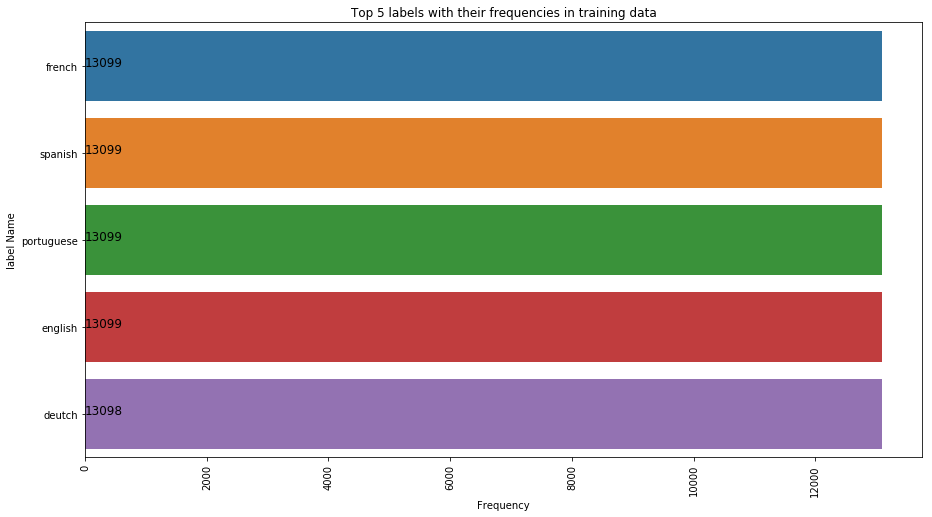

In [15]:
print("Total number of labels in training data : ",len(data['label'].value_counts()))
print("Labels are : ", data['label'].unique())
plt.figure(figsize=(15,8))
audio_type = data['label'].value_counts().head(5)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('label Name')
plt.title("Top 5 labels with their frequencies in training data")
plt.show()

In [16]:
data['gender'] = data['file_name'].apply(lambda n: n.split('_')[1])

## Instâncias por idioma

In [17]:
temp = data['label'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by language')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por quantidade de frames (amostras)

In [18]:
temp = samples['nframes'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por sample rate (amostras)

In [19]:
temp = samples['sample_rate'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por duração total (amostras)

In [20]:
def duration(nframes, sample_rate):
    return sample_rate / nframes

In [21]:
samples['duration'] = pandas.DataFrame([duration(sr, b) for sr, b
                                        in zip(samples['sample_rate'], 
                                               samples['nframes'])])
temp = samples['duration'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by duration')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por gênero

In [22]:
temp = data['gender'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Gender')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por contagem de locutores

In [23]:
speakers_count = dict()
for lang in data['label']:
    speakers_count[lang] = 0
counted = set()
for lang, fname in zip(data['label'], data['file_name']):
    if fname not in counted:
        speakers_count[lang] += 1
        counted.add(fname)
        
df_spk = pandas.DataFrame(data=list(zip(speakers_count.keys() ,speakers_count.values())), 
                          columns=['label', 'Speakers (count)'])
df_spk.head()

label  Speakers (count)
0      deutch                28
1     english                28
2      french                28
3  portuguese                29
4     spanish                28

In [24]:
temp = df_spk['Speakers (count)']
labels = df_spk['label']
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Speaker (count)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por locutores

count
label  file_name                      
deutch de_f_0809f__rmx__lp6000.    486
       de_f_1996a__rmx__lp6000.    466
       de_f_26ddc__rmx__lp6000.    488
       de_f_2825f__rmx__lp6000.    467
       de_f_40479__rmx__lp6000.    444

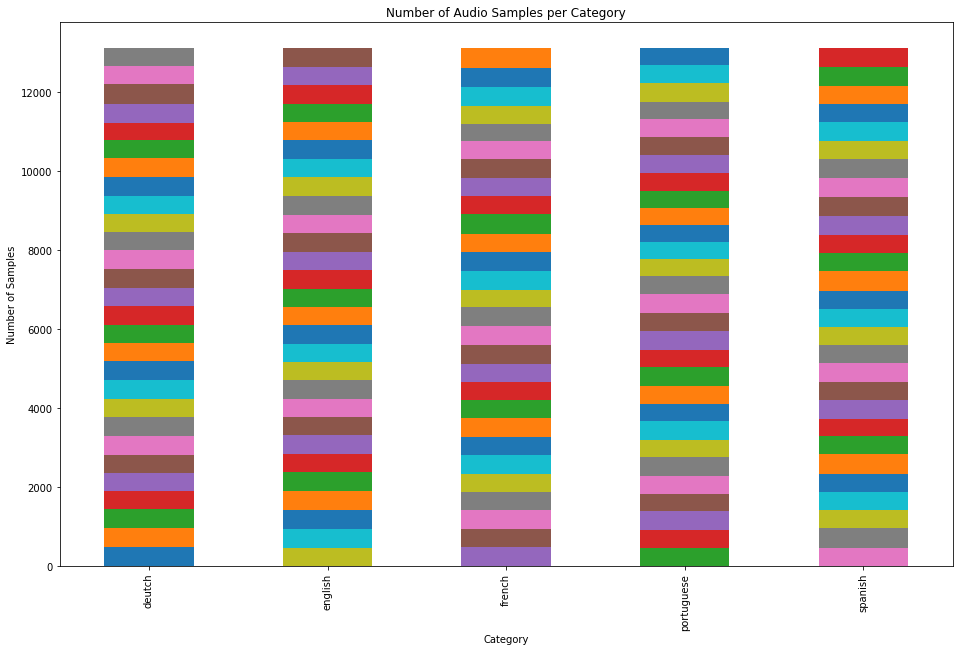

In [25]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['file_name']), 
                        columns=['count', 'label', 'file_name'])
category_group = temp.groupby(['label', 'file_name']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
plot.get_legend().remove()
category_group.head()

## Instâncias por idioma e gênero

count
label      gender       
deutch     f        6572
           m        6526
english    f        6550
           m        6549
french     f        6547
           m        6552
portuguese f        5956
           m        7143
spanish    f        6506
           m        6593

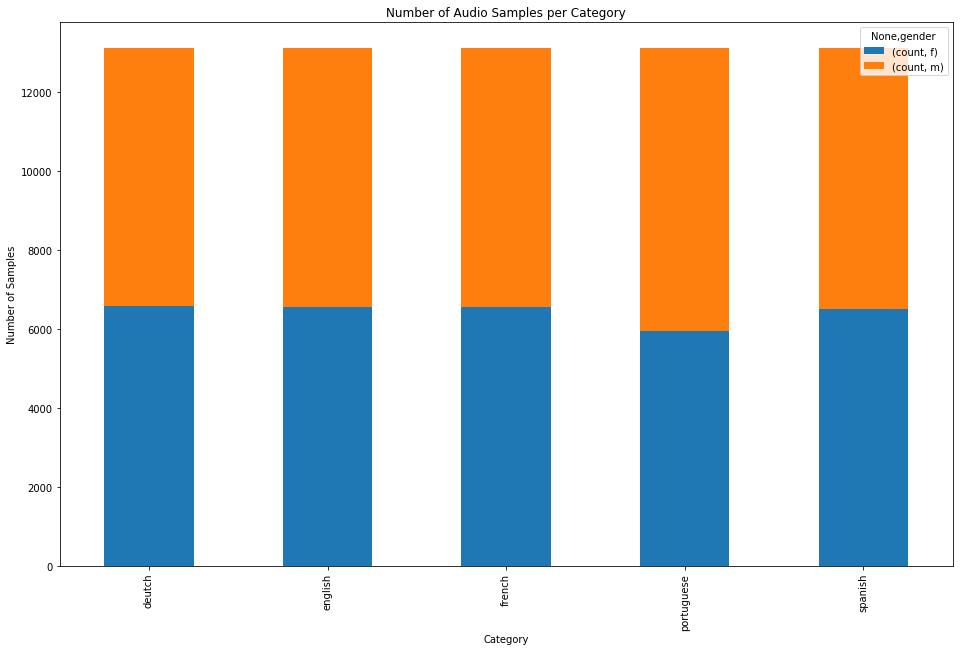

In [26]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['gender']), 
                        columns=['count', 'label', 'gender'])
category_group = temp.groupby(['label', 'gender']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

## Instâncias por _data augmentation_

In [27]:
temp = data['augmented_data'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Data Augmentation')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por idioma e _data augmentation_

count
label      augmented_data       
deutch     True            13098
english    True            13099
french     True            13099
portuguese True            13099
spanish    True            13099

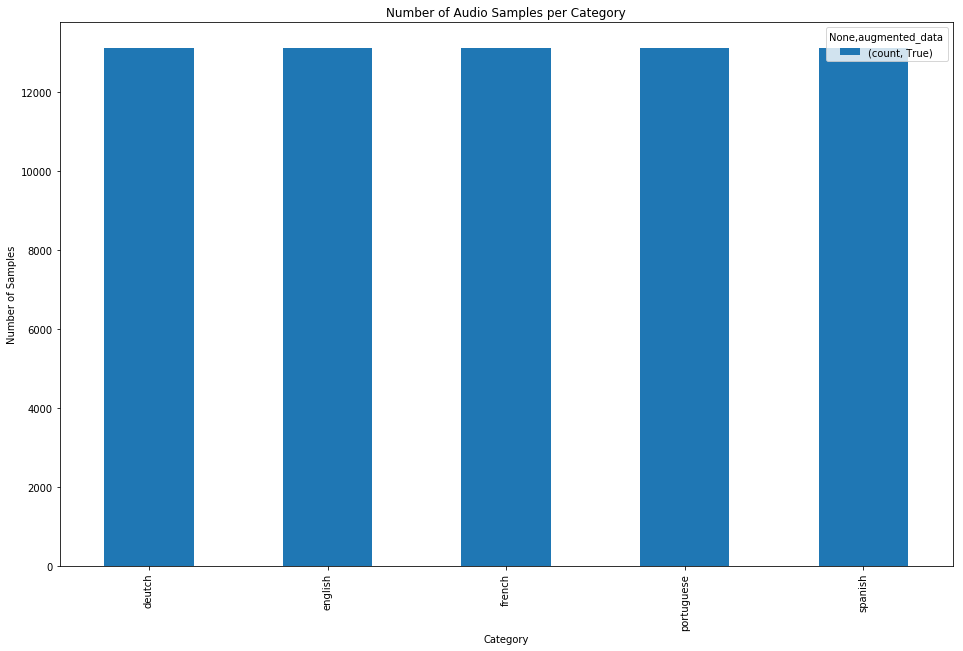

In [28]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['augmented_data']), 
                        columns=['count', 'label', 'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

count  speed_changing  pitch_changing  noise_add  \
label      augmented_data                                                     
deutch     True            13098            5061            4943       2476   
english    True            13099            5059            4947       2472   
french     True            13099            5052            4952       2476   
portuguese True            13099            5036            4959       2487   
spanish    True            13099            5046            4958       2476   

                           low_pass  
label      augmented_data            
deutch     True               13098  
english    True               13099  
french     True               13099  
portuguese True               13099  
spanish    True               13099

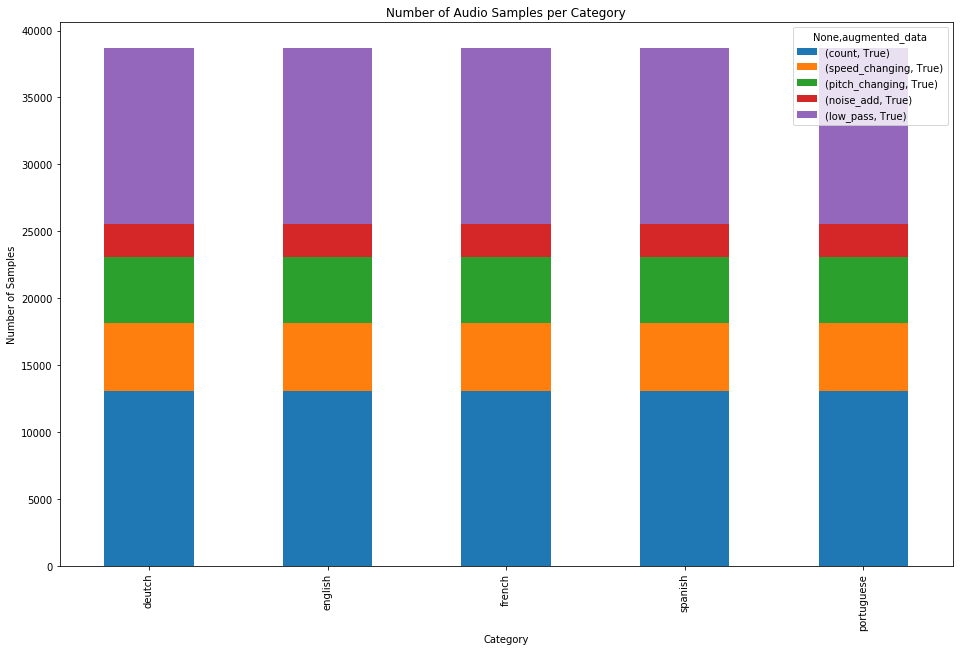

In [29]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['speed_changing'],
                            data['pitch_changing'], data['noise_add'], data['low_pass'], data['augmented_data']), 
                        columns=['count', 'label', 'speed_changing', 'pitch_changing', 'noise_add', 'low_pass',
                                'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
#category_group = category_group[category_group.speed_changing != 0]
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group.head()

## Waveform 

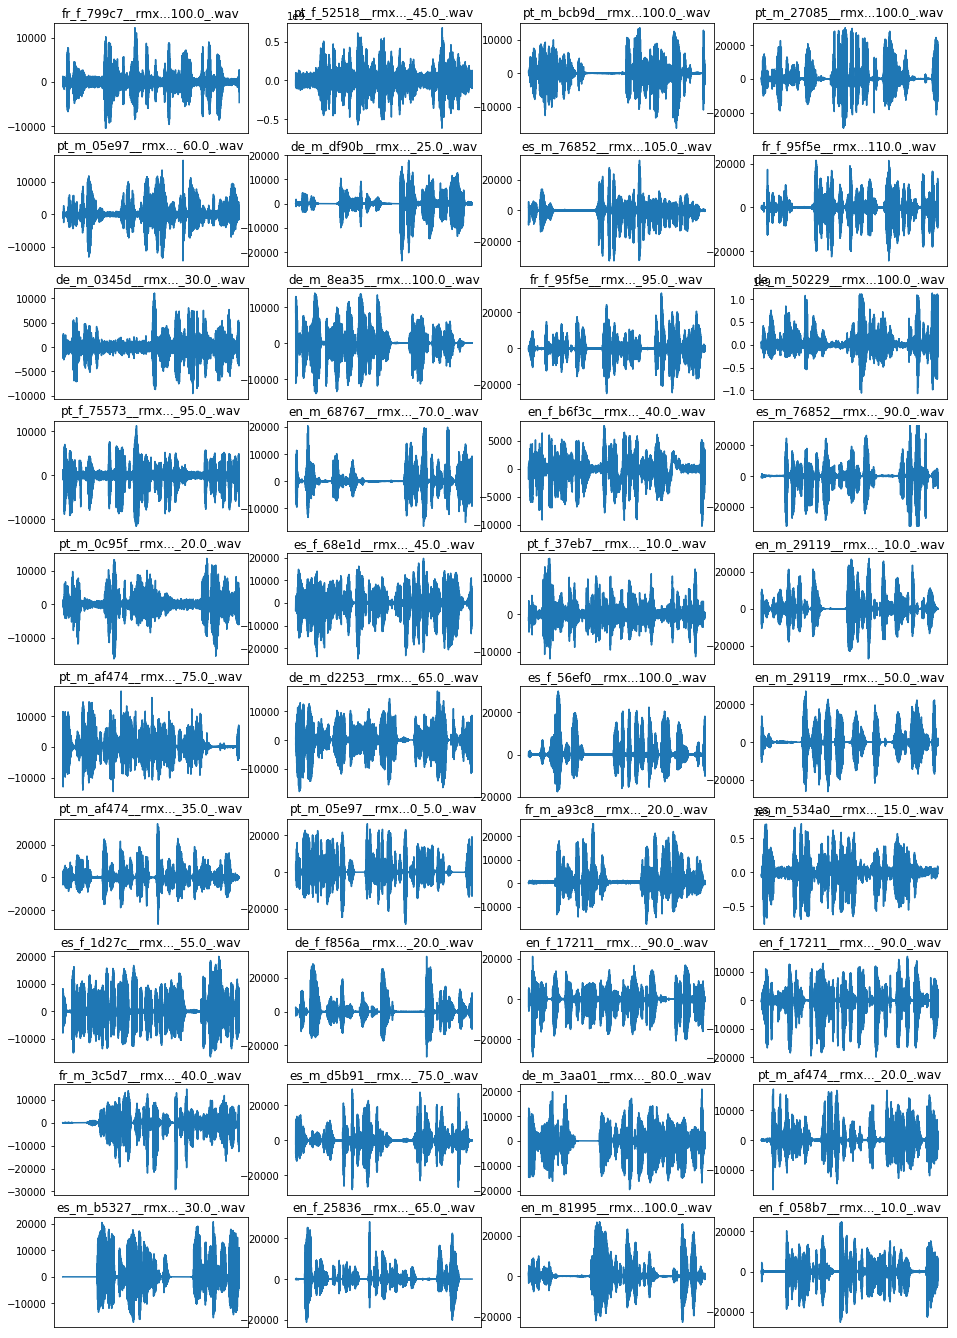

In [30]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    ax[i//4, i%4].plot(samples['time_series'][idx])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioWaveform-{}-{}".format(DATASET, GROUP), dpi=900) 

## Spectrogram

In [31]:
sr, b = wavfile.read(data['file_path'][0])

In [32]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

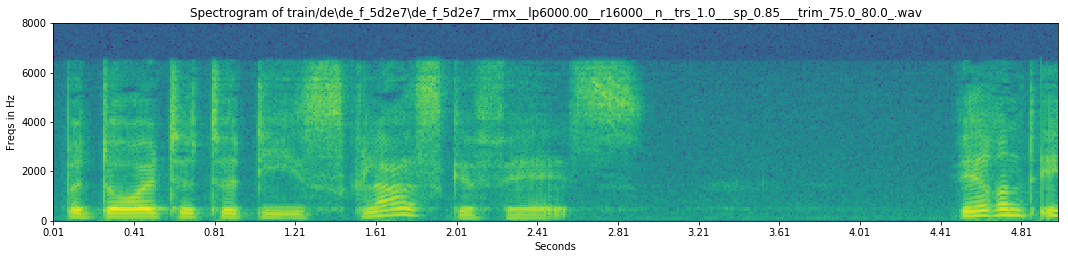

In [33]:
freqs, times, spectrogram = log_specgram(b, sr)

fig = plt.figure(figsize=(18, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::40])
ax2.set_xticks(times[::40])
ax2.set_title('Spectrogram of ' + data['file_path'][0])
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [34]:
print("Size of training data", data.shape)

Size of training data (65494, 9)


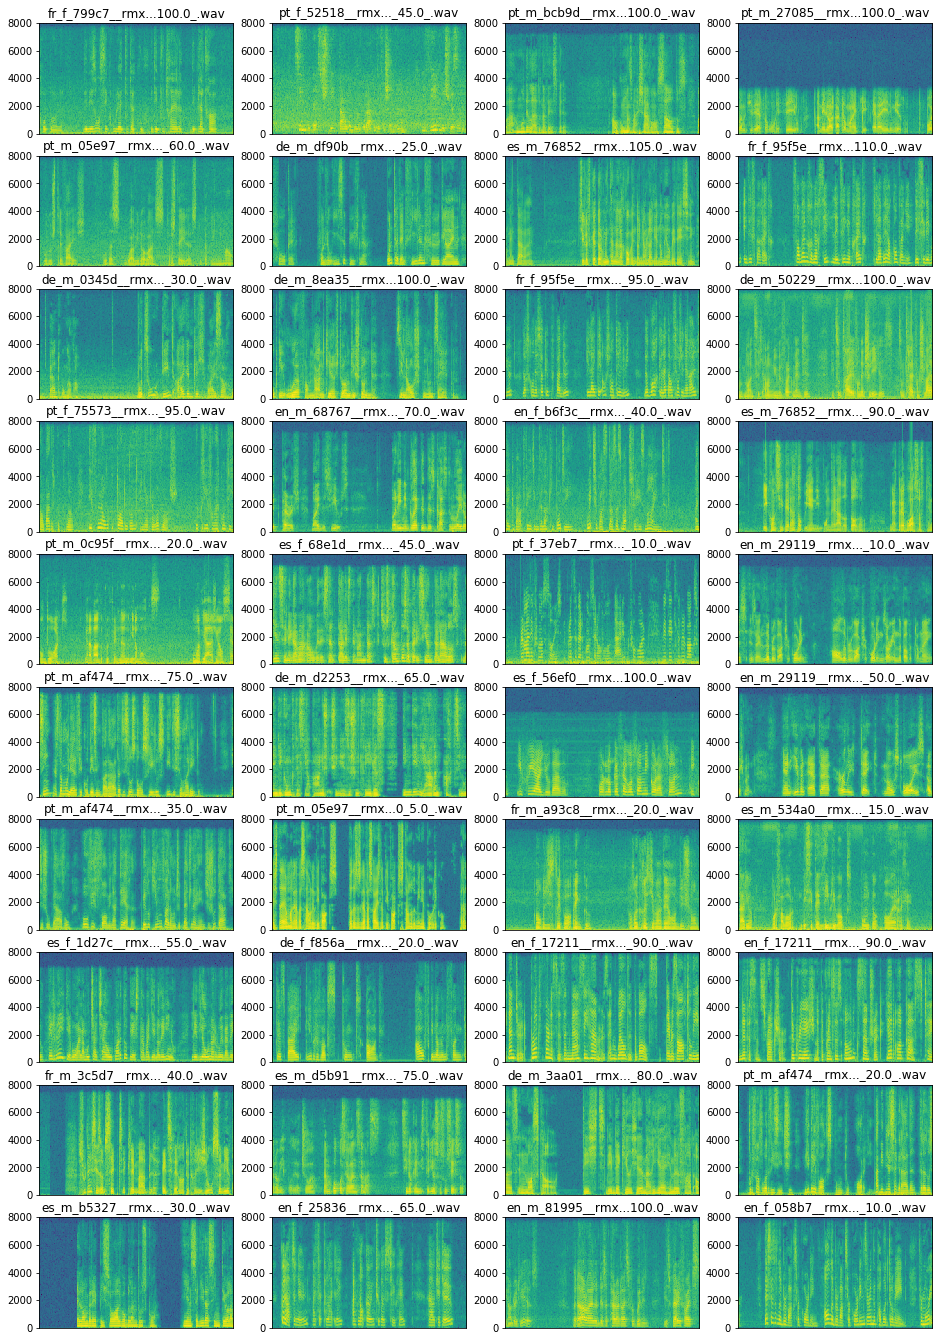

In [35]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = log_specgram(samples['time_series'][idx], sr)
    ax[i//4, i%4].imshow(spectrogram.T, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::40])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioSpectrograms-{}-{}".format(DATASET, GROUP), dpi=900) 

## MFCC

In [36]:
def mfcc_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc

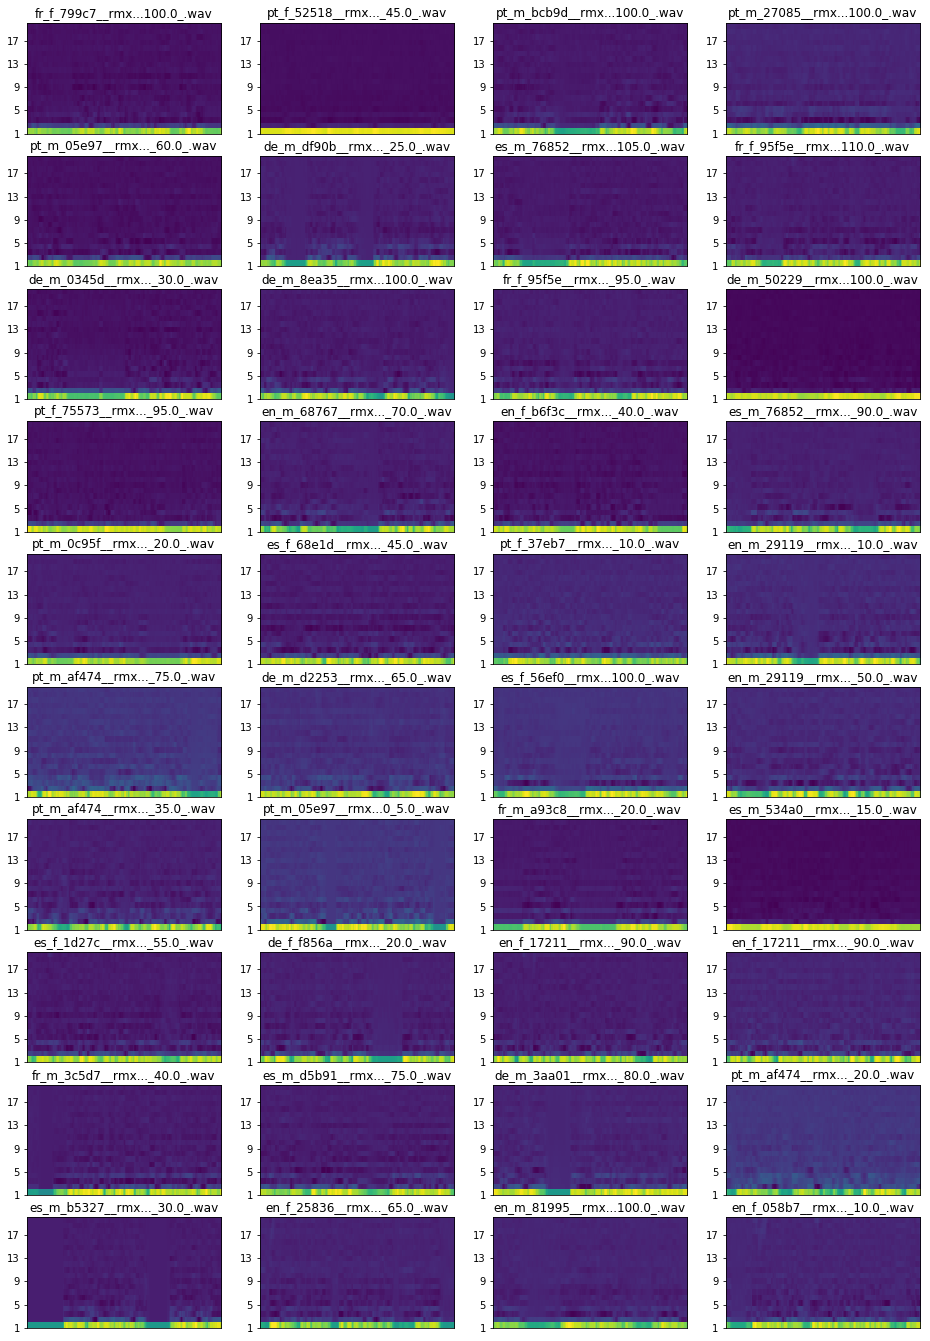

In [37]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_specgram(samples['time_series'][idx], sr,
                                              samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMFCCs-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta

In [38]:
def mfcc_delta_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

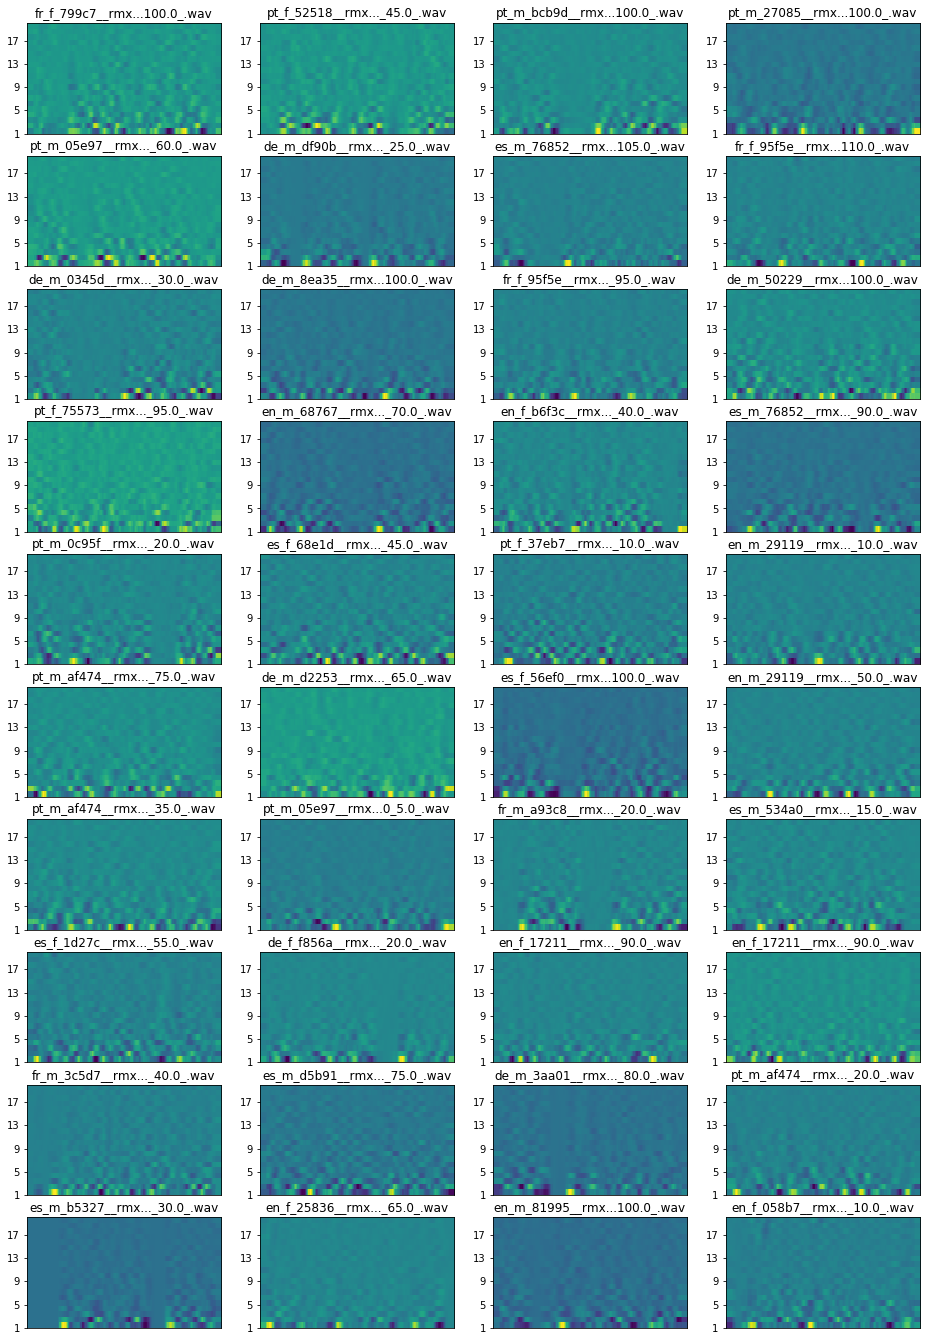

In [39]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_delta_specgram(samples['time_series'][idx], sr,
                                                    samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta Deltas

In [40]:
def mfcc_dd_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc, order=2)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

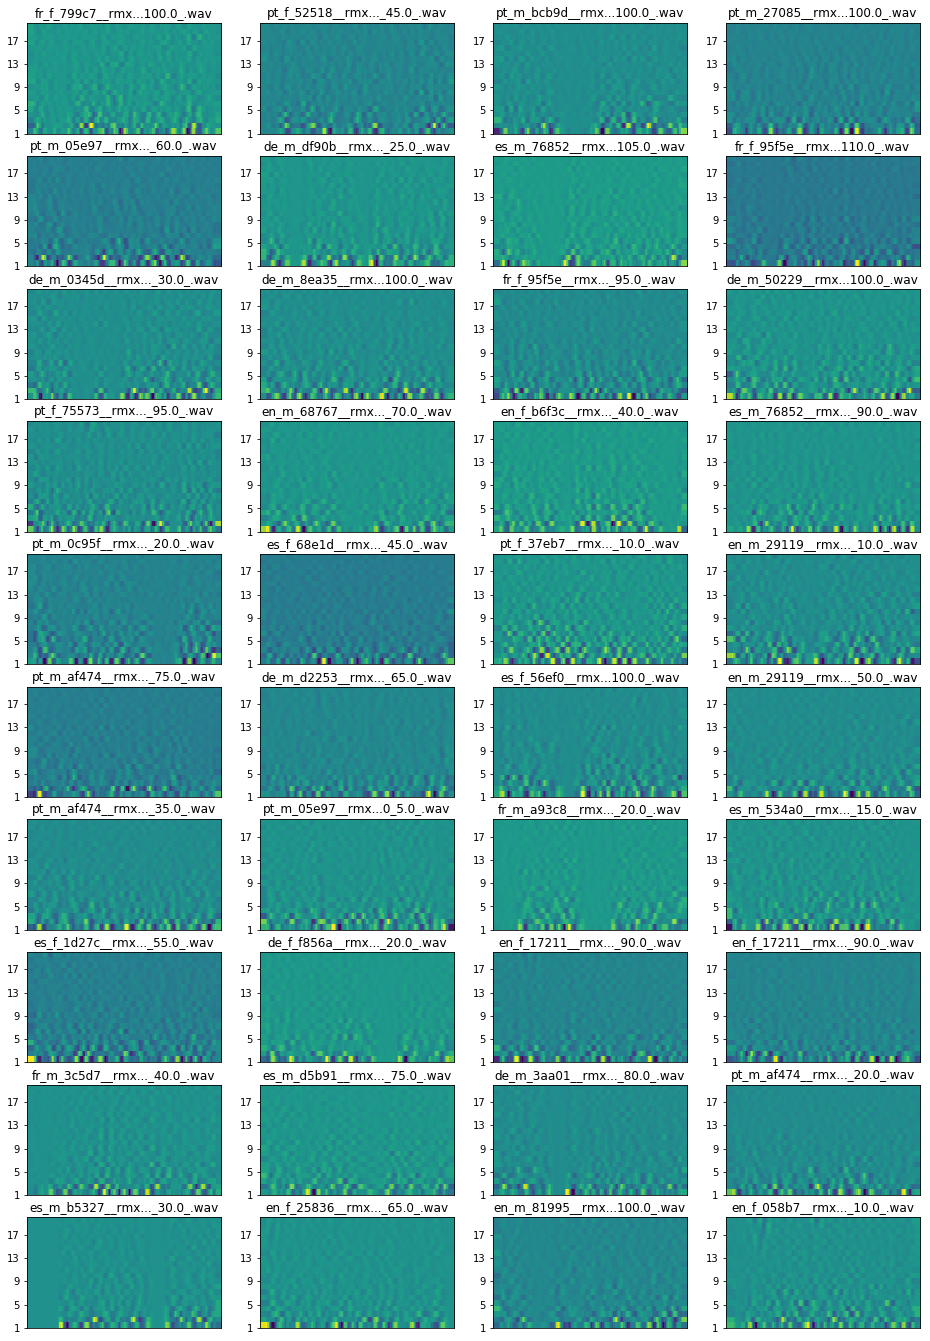

In [41]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_dd_specgram(samples['time_series'][idx], sr,
                                                 samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltaDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

## Mel Spectrogram

In [42]:
def mel_specgram(audio, sample_rate, nframes):
    spec = librosa.feature.melspectrogram(np.asarray(audio, dtype='Float64'), 
                                          sample_rate)
    times = np.linspace(0, nframes/sample_rate, spec.shape[0])
    freqs = np.linspace(1, spec.shape[1], spec.shape[1])
    return freqs, times, spec

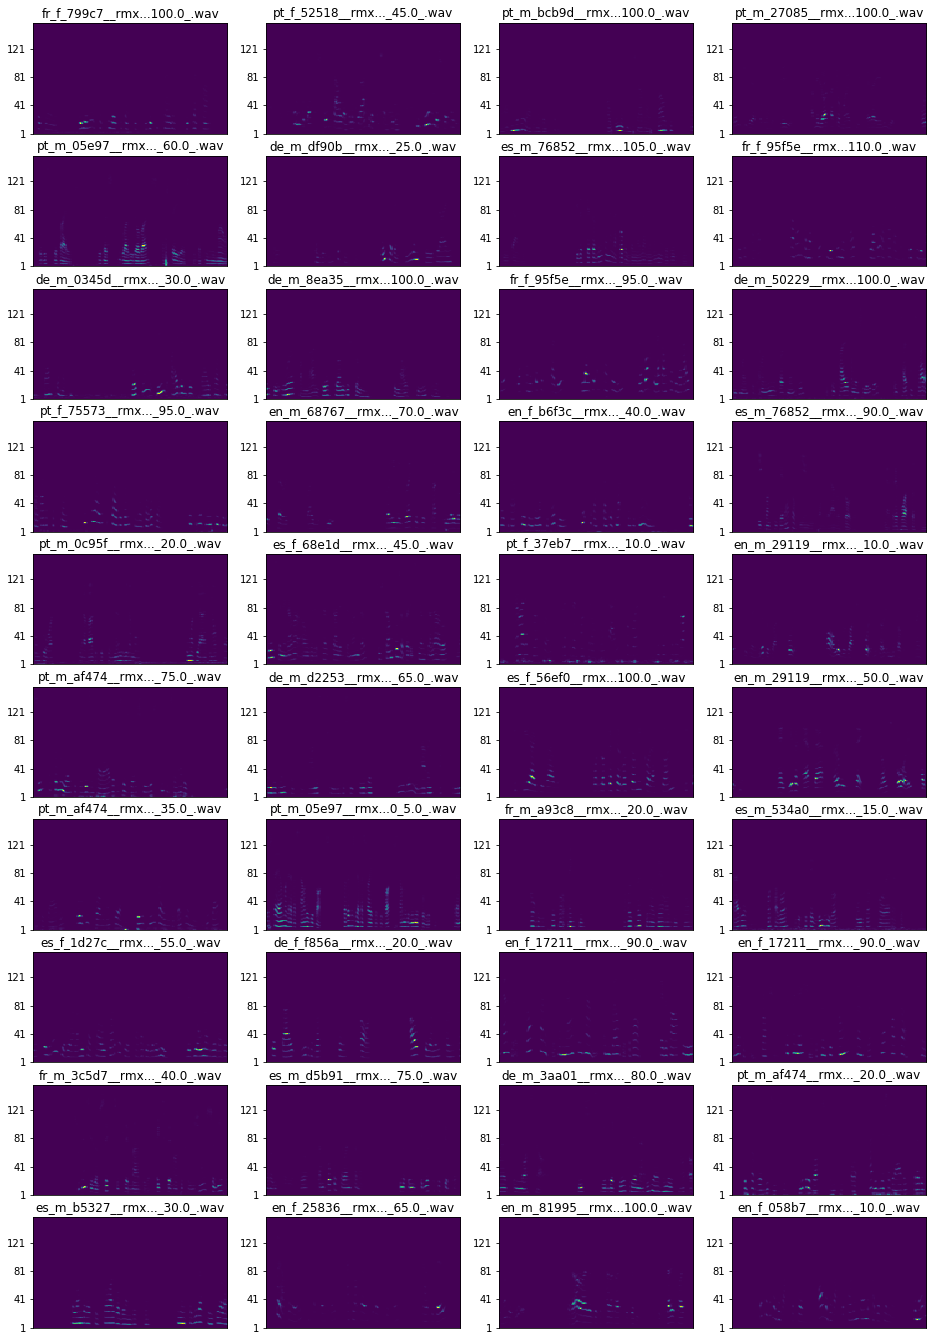

In [43]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mel_specgram(samples['time_series'][idx], sr,
                                             samples['nframes'][idx])
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMelSpecs-{}-{}".format(DATASET, GROUP), dpi=900)  